In [49]:
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
seed = 42

#### TODO

#### 1. ML Performance with default parameters for PATECTGAN , DPGAN and Quail
#### 2. Loss function Plot
#### 3. Distributional Similarity Plot
#### 4. ML Utility Code (done)
#### 5. pMSE code (done)
#### 6. Experimental Setup & Result compare Template
#### 7. Compare methodology (Descriptive)
#### 8. Before (done) and After Coorelation plot 
#### 9. Excel / plot for ML Utility
#### 10. Fix pmse Code


### PMSE ratio calculation

In [3]:
# https://test.ocom.vn/?url=github.com/opendp/smartnoise-sdk/blob/main/dpsdgym/metrics/pmse.py
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def pmse_ratio(data, synthetic_data):
    """
    Reference: https://test.ocom.vn/?url=github.com/opendp/smartnoise-sdk/blob/main/dpsdgym/metrics/pmse.py

  In order to determine how similar the syntheitc and real data are
  to each other *general quality of synthetic) we can train a
  discriminator to attempt to distinguish between real and
  synthetic. The poorer the performance of the discriminator, the
  more similar the two datasets are.

  From "Really Useful Synthetic Data
  A Framework To Evaluate The Quality Of
  Differentially Private Synthetic Data"
  https://arxiv.org/pdf/2004.07740.pdf

  :param data: Original data
  :type data: pandas DataFrame
  :param synthetic_data: Synthetic data we are analyzing
  :type synthetic_data: pandas DataFrame
  :return: ratio (pmse score)
  :rtype: float
  """
    n1 = data.shape[0]
    n2 = synthetic_data.shape[0]
    comb = pd.concat([data, synthetic_data], axis=0, keys=[0, 1]).reset_index(level=[0]).rename(columns={'level_0': 'indicator'})
    X_comb = comb.drop('indicator', axis=1)
    y_comb = comb['indicator']
    X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.33, random_state=42)
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    score = clf.predict_proba(X_comb)[:, 1]
    observed_utility = sum((score - n2/(n1 + n2))**2) / (n1 + n2)
    expected_utility = clf.coef_.shape[1] * (n1/(n1 + n2))**2 * (n2/(n1 + n2)) / (n1 + n2)
    ratio = observed_utility / expected_utility
    return ratio

In [53]:
def dp_kde_quick(real_dataset, synth_datasets_dict, features):
    real_pp = real_dataset["fraud_bool"].mean()
    real_label = f"Real prepay_rate:{real_pp:.2%}"

    sns.set()

    for feat in features:
        fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
        sns.kdeplot(real_dataset[feat], label = real_label, ax = ax[0])
        sns.kdeplot(real_dataset[feat], label = real_label, ax = ax[1])

        for l, synth in list(synth_datasets_dict.items()):
            synth_pp = synth["fraud_bool"].mean()
            l += f" prepay_rate:{synth_pp:.2%}"

            if ("gen2" in l):
                sns.kdeplot(synth[feat], label = l, ax = ax[0])
            else:
                sns.kdeplot(synth[feat], label = l, ax = ax[1])

        ax[0].legend(prop={'size': 7})
        ax[0].set_title(f"KDE of {feat} ")

        ax[1].legend(prop={'size': 7})
        ax[1].set_title(f"KDE of {feat}")


In [5]:
def plot_logs(logs, split_key = "None"):
    fix, ax = plt.subplots(1, 2, figsize = (9, 5), sharey = True)

    for l, log in logs.items():
        log = log.reset_index()

        ax[0].plot(log.index, log["Loss G"], label = l)

        ax[1].plot(log.index, log["Loss D"], label = l)

    ax[0].lengend(prop={'size': 8})
    ax[0].set_title("Generator")
    ax[1].lengend(prop={'size': 8})
    ax[1].set_title("Discriminator")

    plot_logs(logs, "loss: wasserstein")

In [6]:
def get_performance_metrics(classification_report):
    if len(classification_report.split('\n')) ==9:
        precision = classification_report.split('\n')[3].split()[1]
        recall = classification_report.split('\n')[3].split()[2]
        f1_score = classification_report.split('\n')[3].split()[3]
    if len(classification_report.split('\n')) ==8:
        precision = classification_report.split('\n')[2].split()[1]
        recall = classification_report.split('\n')[2].split()[2]
        f1_score = classification_report.split('\n')[2].split()[3]
    return precision, recall, f1_score

In [7]:
def evaluate_performance(clf, X_train, y_train, X_test, y_test, result_key, result_type, features):
    label_prefix_list = ['Train','Test']
    result_list = []
    
    for label in label_prefix_list:
        if label == 'Test':
            y_pred= clf.predict(X_test)
            cr = classification_report(y_test, y_pred)
            
            precision, recall, f1_score = get_performance_metrics(cr)
            y_probs = clf.predict_proba(X_test)
            if np.shape(y_probs)[1] ==2:
                roc_score = np.round(roc_auc_score(y_test,y_probs[:,1]),4)
            else:
                roc_score = float("nan")
            result_list.append([str(result_key),result_type,'test',features,precision, recall, f1_score,roc_score])

            
        else:
            y_pred= clf.predict(X_train)
            cr = classification_report(y_train, y_pred)
            
            precision, recall, f1_score = get_performance_metrics(cr)
            y_probs = clf.predict_proba(X_train)
            if np.shape(y_probs)[1] ==2:
                roc_score = np.round(roc_auc_score(y_train,y_probs[:,1]),4)
            else:
                roc_score = float("nan")
            result_list.append([str(result_key),result_type,'train',features,precision, recall, f1_score,roc_score])

    return result_list
             

In [8]:
def get_train_test_split(df, test_size, seed, label):
    xy_train, xy_test = train_test_split(df, test_size=test_size, stratify=df[label],random_state=seed)
    return xy_train, xy_test

In [9]:
def get_train_test_df_for_model(xy_train, xy_test,label):
    X_train = xy_train.drop(label,axis=1)
    y_train = xy_train[label]
    y_train = y_train.astype('int')
    
    X_test = xy_test.drop(label,axis=1)
    y_test = xy_test[label]
    y_test = y_test.astype('int')
    return X_train, X_test, y_train, y_test

In [10]:
def fit_the_model(X_train, y_train, n_estimators, max_depth, seed, class_weight):
    clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, random_state=seed, 
                                 class_weight=class_weight)
    clf.fit(X_train, y_train)
    return clf

In [11]:
def get_result_df(result_list,col_list):
    dfResult = pd.DataFrame(result_list, columns=col_list)
    print(dfResult.shape)
    return dfResult

In [12]:
from io import StringIO, BytesIO
import pickle
def write_pickle(file_path,arr):
    with open(file_path,'wb') as f:
        pkl.dump(arr,f)

In [13]:
def read_pickle(file_path):
    with open(file_path,'rb') as f:
        x =pkl.load(f)
        print(x.shape)
        return x

# Execution Block

In [14]:
#dfPrivate_300000x12.npy
#dfPrivate=read_pickle("data/dfPrivate_300000x12.npy")
#with open('data/PATECTGAN.npy','rb') as f:
    #x =pkl.load(f)
    #print(x.shape)

In [15]:
# Load the real data
df_real = pd.read_csv("data/output/dfPrivate.csv")
print(df_real.shape)
df_real.head()

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.4,0.208878,2,5,160,2,1,0,200.0,0,1
1,0,0.8,0.993504,1,1,197,0,0,0,1500.0,3,1
2,0,0.8,0.265069,1,0,163,2,0,1,500.0,0,1
3,0,0.1,0.263270,1,0,193,2,1,0,200.0,3,1
4,0,0.3,0.438486,1,2,41,1,0,1,200.0,2,0


In [16]:
real_column_list = df_real.columns.tolist()
print(real_column_list)

['fraud_bool', 'income', 'name_email_similarity', 'payment_type', 'employment_status', 'credit_risk_score', 'housing_status', 'phone_home_valid', 'has_other_cards', 'proposed_credit_limit', 'device_os', 'keep_alive_session']


In [39]:
df_synthetic_PATECTGAN_5 = pd.read_csv("data/output/PATECTGAN_5.0.csv",names = real_column_list)
print(df_synthetic_PATECTGAN_5.shape)
df_synthetic_PATECTGAN_5.head()

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0.0,0.679844,0.417934,1.0,3.0,95.256664,1.0,1.0,1.0,1164.075537,2.0,0.0
1,0.0,0.943760,0.641898,2.0,0.0,180.755742,0.0,0.0,0.0,753.300770,2.0,1.0
2,0.0,0.668336,0.357404,0.0,5.0,55.017530,1.0,0.0,0.0,350.299252,0.0,1.0
3,0.0,0.900402,0.488387,2.0,0.0,65.364429,0.0,1.0,0.0,207.206333,3.0,1.0
4,0.0,0.975245,0.640574,4.0,1.0,237.775294,2.0,0.0,0.0,971.035760,0.0,0.0


In [40]:
df_synthetic_DPCTGAN_5 = pd.read_csv("data/output/DPCTGAN_5.0.csv",names = real_column_list)
print(df_synthetic_DPCTGAN_5.shape)
df_synthetic_DPCTGAN_5.head()

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0.0,0.945800,0.343928,2.0,2.0,83.905127,1.0,1.0,0.0,128.705700,3.0,0.0
1,0.0,0.704819,0.754589,0.0,0.0,199.338358,0.0,1.0,0.0,841.778963,3.0,0.0
2,0.0,0.616818,0.766674,0.0,0.0,146.199371,2.0,0.0,1.0,965.910910,2.0,1.0
3,0.0,0.934944,0.233757,2.0,1.0,41.842606,2.0,0.0,0.0,151.908367,3.0,0.0
4,0.0,0.441069,0.073536,1.0,0.0,194.090822,4.0,1.0,1.0,128.060253,3.0,1.0


In [41]:
df_synthetic = df_synthetic_DPCTGAN_5.copy()

print(df_synthetic.shape)
df_synthetic.head()


(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0.0,0.945800,0.343928,2.0,2.0,83.905127,1.0,1.0,0.0,128.705700,3.0,0.0
1,0.0,0.704819,0.754589,0.0,0.0,199.338358,0.0,1.0,0.0,841.778963,3.0,0.0
2,0.0,0.616818,0.766674,0.0,0.0,146.199371,2.0,0.0,1.0,965.910910,2.0,1.0
3,0.0,0.934944,0.233757,2.0,1.0,41.842606,2.0,0.0,0.0,151.908367,3.0,0.0
4,0.0,0.441069,0.073536,1.0,0.0,194.090822,4.0,1.0,1.0,128.060253,3.0,1.0


In [24]:
# Config parameters
real_result_key="df_300Krows_12cols"
features=11
result_column_list = ["model_key", "model_type","model_split","number_of_features","precision","recall",
                   "f1_score","ROC-AUC"]
epsilon=3.0
synthesizer=["DP-CTGAN","PATE-CTGAN"]
isQuail = False
quail_model=["QUAIL_DPLR","QUAIL_DPNB"]
if not isQuail: 
    synthetic_result_key = "synthetic_300Krows_12cols_epsilon_{}_synthesizer_{}".format(epsilon,synthesizer[0])
else:
    synthetic_result_key = "synthetic_300Krows_12cols_epsilon_{}_synthesizer_{}_model_".format(
        epsilon,synthesizer[1],quail_model[1])


In [25]:
print(type(df_synthetic))
print(type(df_real))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [26]:
# distribution Metrics
pmse = pmse_ratio(df_real, df_synthetic)
print(pmse)

8387.17317220141


/Users/krishnakumar/opt/anaconda3/envs/cs7643-project-v1/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
df_real_train, df_real_test = get_train_test_split(df_real, test_size=0.3, seed=42, label="fraud_bool")
print(df_real_train.shape, df_real_test.shape)

(210000, 12) (90000, 12)


In [28]:
X_train_real, X_test_real, y_train_real, y_test_real = get_train_test_df_for_model(df_real_train, df_real_test,
                                                                                   label="fraud_bool")
print(X_train_real.shape, X_test_real.shape, y_train_real.shape, y_test_real.shape)

(210000, 11) (90000, 11) (210000,) (90000,)


In [29]:
# TRTR

clf_real = fit_the_model(X_train_real, y_train_real, n_estimators=100, max_depth=4, seed=seed, 
                         class_weight='balanced')
TRTR_result_list = evaluate_performance(clf_real, X_train_real, y_train_real, X_test_real, y_test_real, 
                                        result_key=real_result_key, result_type="TRTR", features=11)
print("TRTR_result_list {}".format(TRTR_result_list))
df_TRTR_result = get_result_df(TRTR_result_list,result_column_list)
print(df_TRTR_result.shape)
df_TRTR_result.head()

TRTR_result_list [['df_300Krows_12cols', 'TRTR', 'train', 11, '0.04', '0.75', '0.07', 0.8354], ['df_300Krows_12cols', 'TRTR', 'test', 11, '0.03', '0.73', '0.07', 0.8291]]
(2, 8)
(2, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,df_300Krows_12cols,TRTR,train,11,0.04,0.75,0.07,0.8354
1,df_300Krows_12cols,TRTR,test,11,0.03,0.73,0.07,0.8291


In [30]:
df_TRTR_result.to_pickle("data/output/df_TRTR_result.pkl")
unpickled_df_TRTR_result = pd.read_pickle("data/output/df_TRTR_result.pkl")
print(unpickled_df_TRTR_result.shape)
unpickled_df_TRTR_result.head()

(2, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,df_300Krows_12cols,TRTR,train,11,0.04,0.75,0.07,0.8354
1,df_300Krows_12cols,TRTR,test,11,0.03,0.73,0.07,0.8291


In [31]:
# split Synthetic data
df_synthetic_train, df_synthetic_test = get_train_test_split(df_synthetic, test_size=0.3, seed=42, 
                                                             label="fraud_bool")
print(df_synthetic_train.shape, df_synthetic_train.shape)

X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = get_train_test_df_for_model(
    df_synthetic_train, df_synthetic_test,label="fraud_bool")
print(X_train_synthetic.shape, X_test_synthetic.shape, y_train_synthetic.shape, y_test_synthetic.shape)

(210000, 12) (210000, 12)
(210000, 11) (90000, 11) (210000,) (90000,)


In [32]:
# TSTR
clf_synthetic = fit_the_model(X_train_synthetic, y_train_synthetic, n_estimators=100, max_depth=4, seed=seed, 
                         class_weight='balanced')
TSTR_result_list = evaluate_performance(clf_synthetic, X_train_synthetic, y_train_synthetic, X_test_real, 
                                        y_test_real, result_key=synthetic_result_key, result_type="TSTR", 
                                        features=11)
print("TSTR_result_list {}".format(TSTR_result_list))
df_TSTR_result = get_result_df(TSTR_result_list,result_column_list)
print(df_TSTR_result.shape)
df_TSTR_result.head()

TSTR_result_list [['synthetic_300Krows_12cols_epsilon_3.0_synthesizer_DP-CTGAN', 'TSTR', 'train', 11, '0.00', '1.00', '0.01', 0.9862], ['synthetic_300Krows_12cols_epsilon_3.0_synthesizer_DP-CTGAN', 'TSTR', 'test', 11, '0.08', '0.26', '0.12', 0.7947]]
(2, 8)
(2, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTR,train,11,0.00,1.00,0.01,0.9862
1,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTR,test,11,0.08,0.26,0.12,0.7947


In [33]:
df_TSTR_result.to_pickle("data/output/df_TSTR_result_{}.pkl".format("DP-CTGAN"))
unpickled_df_TSTR_result = pd.read_pickle("data/output/df_TSTR_result_{}.pkl".format("DP-CTGAN"))
print(unpickled_df_TSTR_result.shape)
unpickled_df_TSTR_result.head()

(2, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTR,train,11,0.00,1.00,0.01,0.9862
1,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTR,test,11,0.08,0.26,0.12,0.7947


In [34]:
# TSTS
TSTS_result_list = evaluate_performance(clf_synthetic, X_train_synthetic, y_train_synthetic, X_test_synthetic, 
                                        y_test_synthetic, result_key=synthetic_result_key, result_type="TSTS", 
                                        features=11)
print("TSTS_result_list {}".format(TSTS_result_list))
df_TSTS_result = get_result_df(TSTS_result_list,result_column_list)
print(df_TSTS_result.shape)
df_TSTS_result.head()

TSTS_result_list [['synthetic_300Krows_12cols_epsilon_3.0_synthesizer_DP-CTGAN', 'TSTS', 'train', 11, '0.00', '1.00', '0.01', 0.9862], ['synthetic_300Krows_12cols_epsilon_3.0_synthesizer_DP-CTGAN', 'TSTS', 'test', 11, '0.00', '0.79', '0.00', 0.9705]]
(2, 8)
(2, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTS,train,11,0.00,1.00,0.01,0.9862
1,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTS,test,11,0.00,0.79,0.00,0.9705


In [35]:
df_TSTS_result.to_pickle("data/output/df_TSTS_result_{}.pkl".format("DP-CTGAN"))
unpickled_df_TSTS_result = pd.read_pickle("data/output/df_TSTS_result_{}.pkl".format("DP-CTGAN"))
print(unpickled_df_TSTS_result.shape)
unpickled_df_TSTS_result.head()

(2, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTS,train,11,0.00,1.00,0.01,0.9862
1,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTS,test,11,0.00,0.79,0.00,0.9705


In [36]:
df_result = pd.concat([df_TRTR_result, df_TSTR_result, df_TSTS_result])
print(df_result.shape)
df_result.head()

(6, 8)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC
0,df_300Krows_12cols,TRTR,train,11,0.04,0.75,0.07,0.8354
1,df_300Krows_12cols,TRTR,test,11,0.03,0.73,0.07,0.8291
0,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTR,train,11,0.00,1.00,0.01,0.9862
1,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTR,test,11,0.08,0.26,0.12,0.7947
0,synthetic_300Krows_12cols_epsilon_3.0_synthesi...,TSTS,train,11,0.00,1.00,0.01,0.9862


In [ ]:
# Include pmse
df_result["pmse"] = pmse
print(df_result.shape)
df_result.head()

In [37]:
df_result.to_csv("data/output/df_result_epsilon_{}_synth_{}.csv".format(epsilon,"DP-CTGAN"))

In [38]:
feature_list = [x for x in real_column_list if x not in ['fraud_bool']]
print(feature_list)

['income', 'name_email_similarity', 'payment_type', 'employment_status', 'credit_risk_score', 'housing_status', 'phone_home_valid', 'has_other_cards', 'proposed_credit_limit', 'device_os', 'keep_alive_session']


In [43]:
synth_dict={"synthetic_PATECTGAN_5":df_synthetic_PATECTGAN_5, "synthetic_DPCTGAN_5": df_synthetic_DPCTGAN_5}

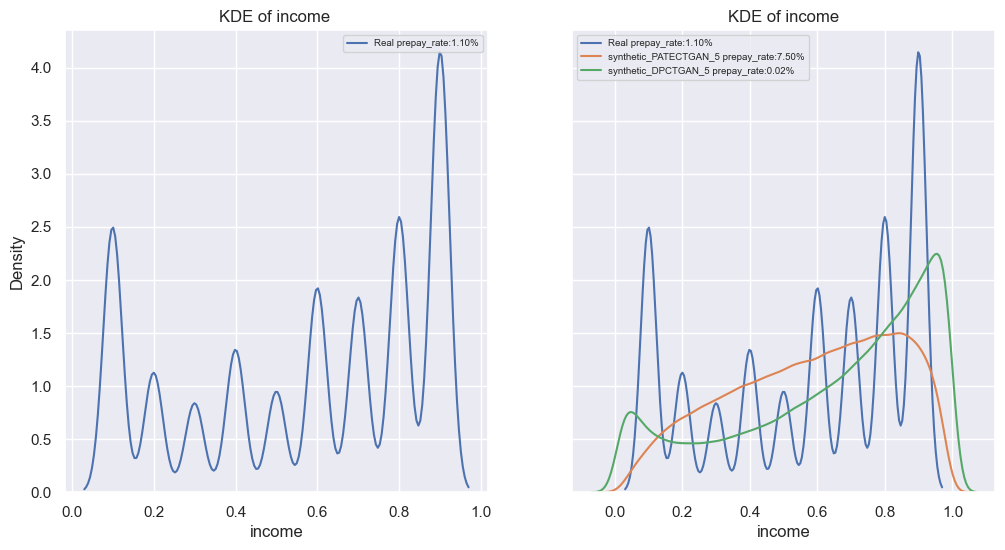

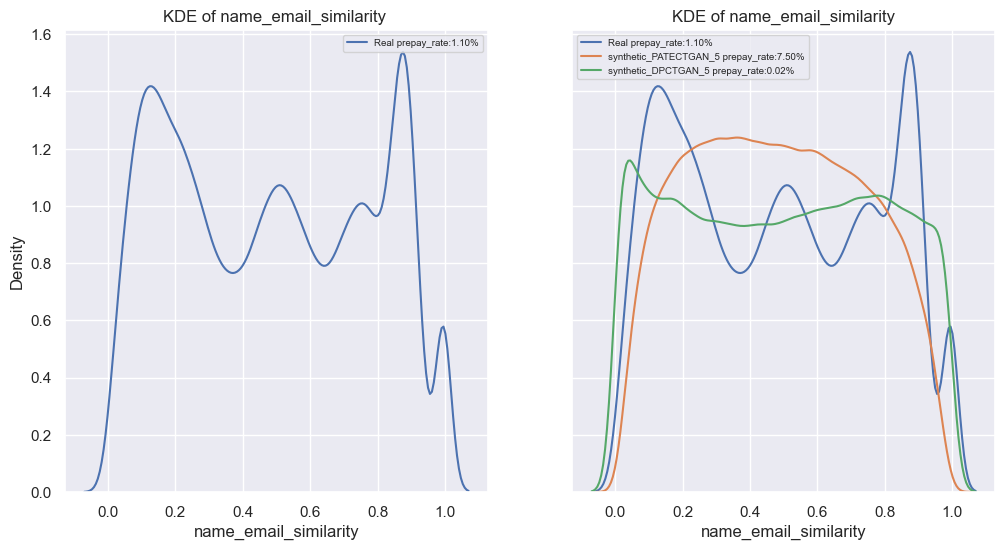

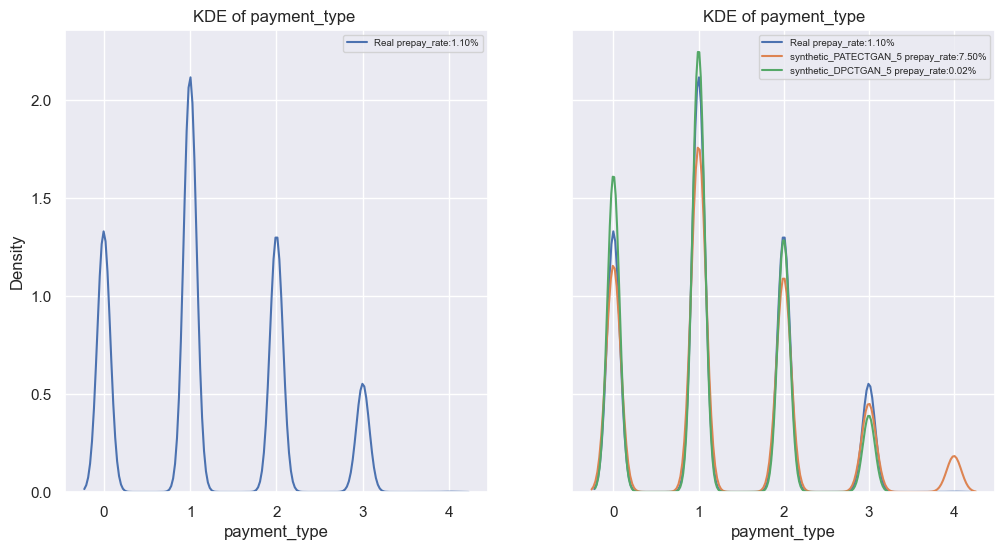

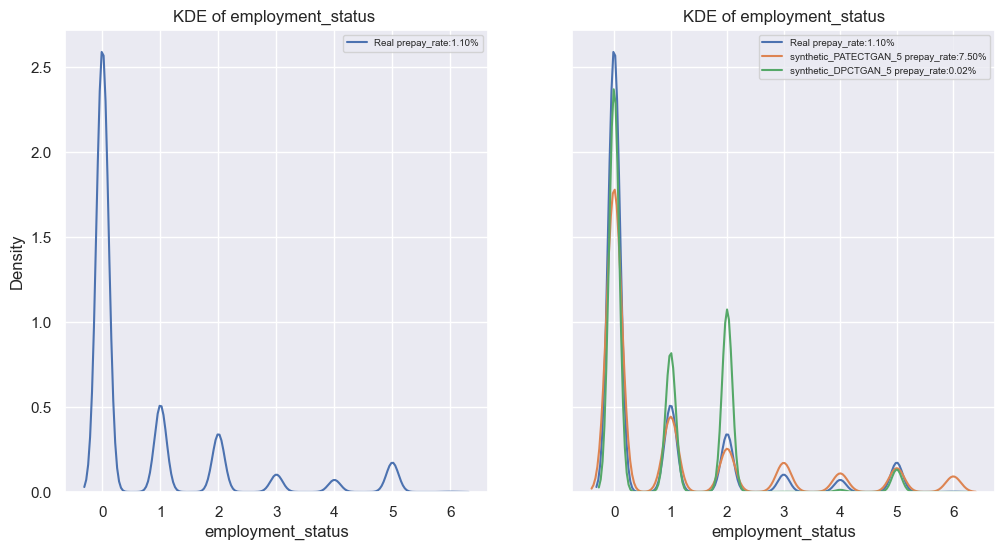

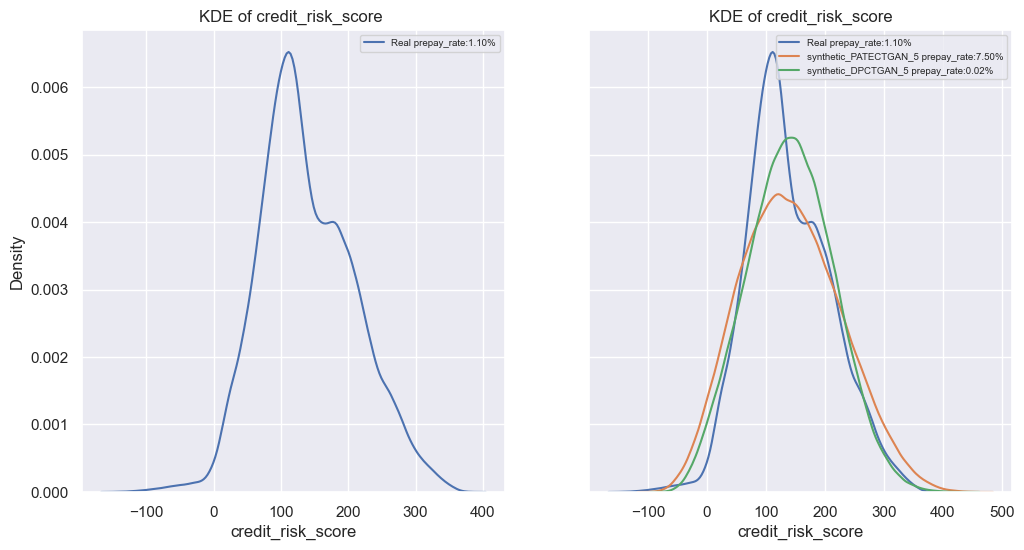

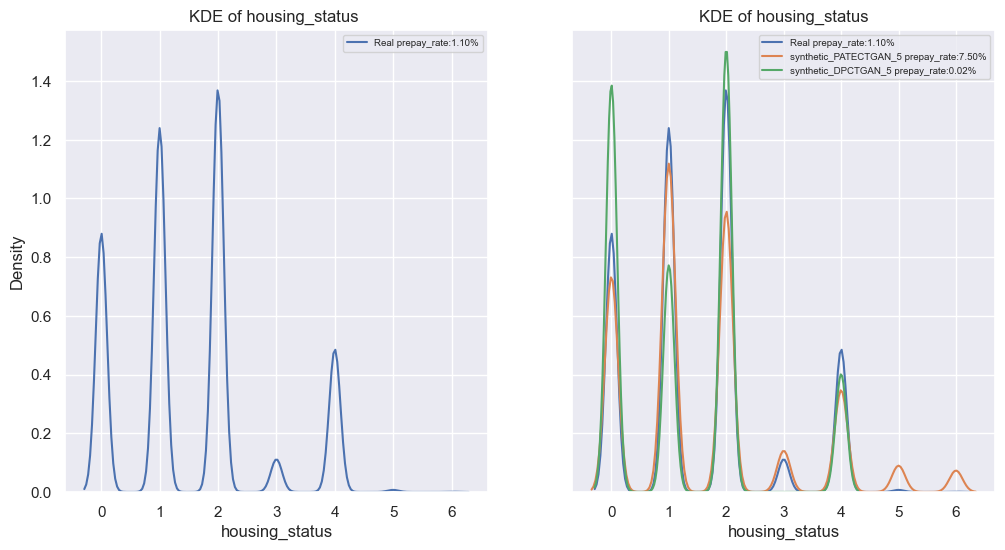

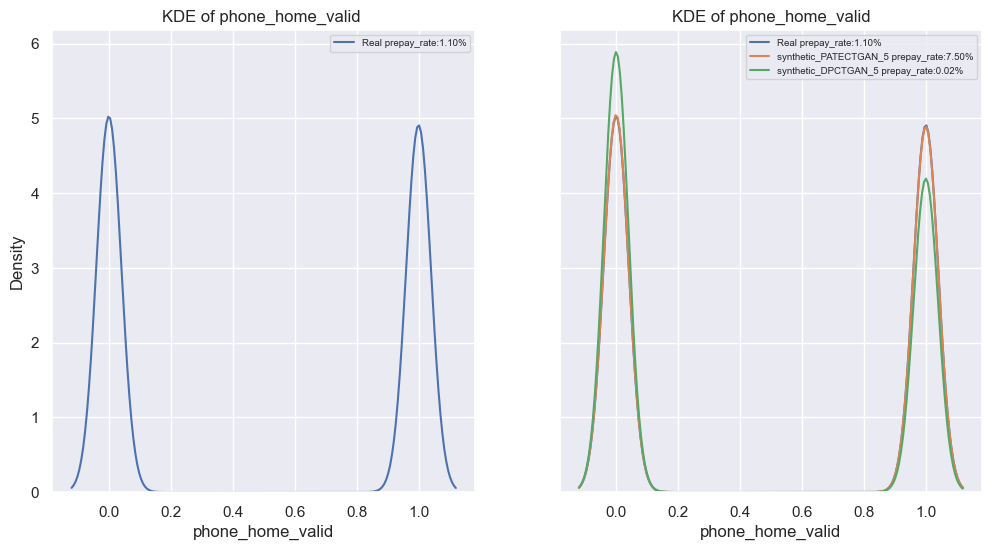

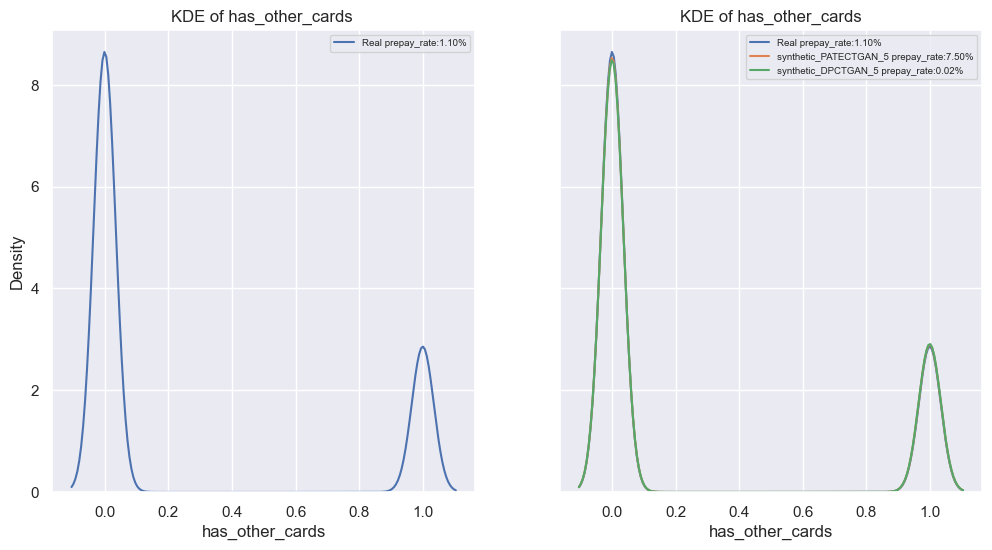

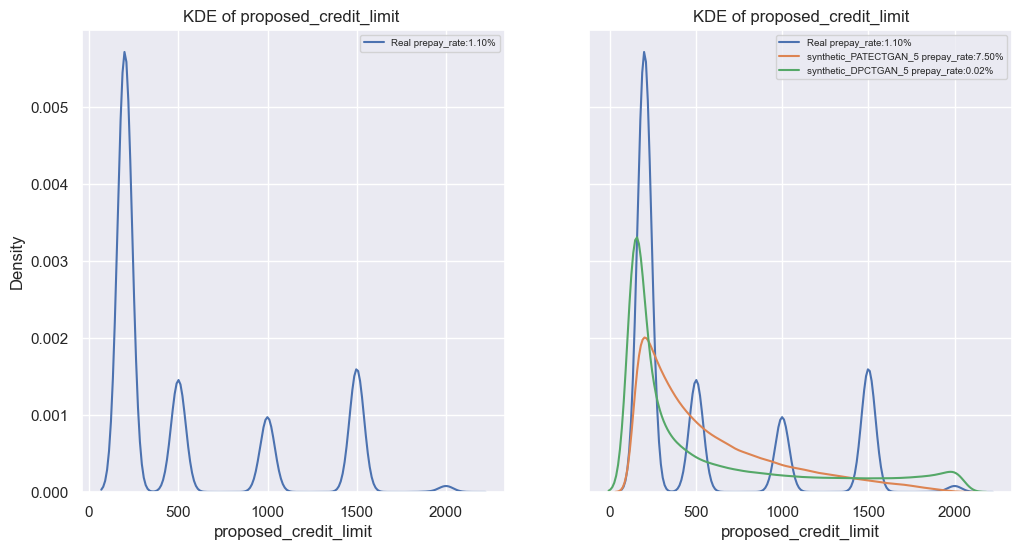

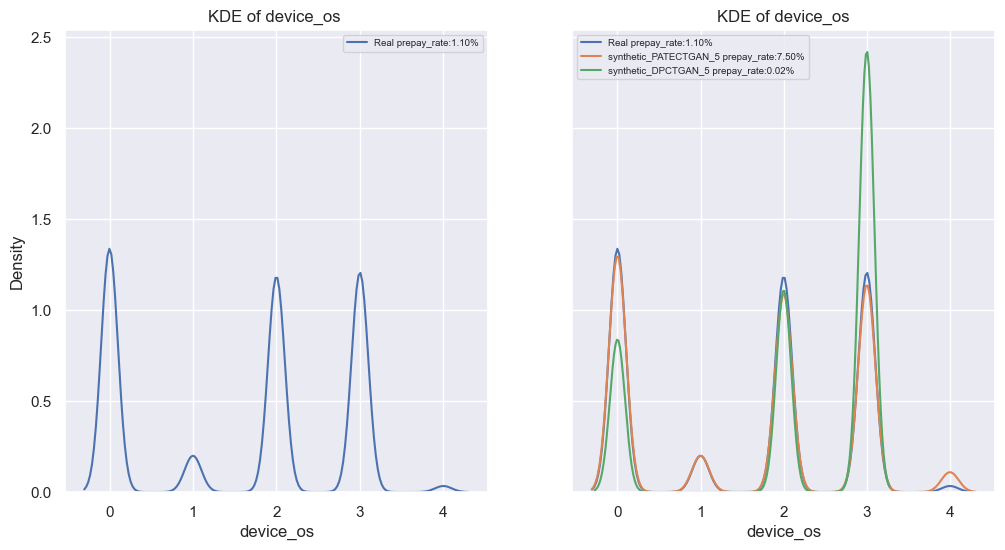

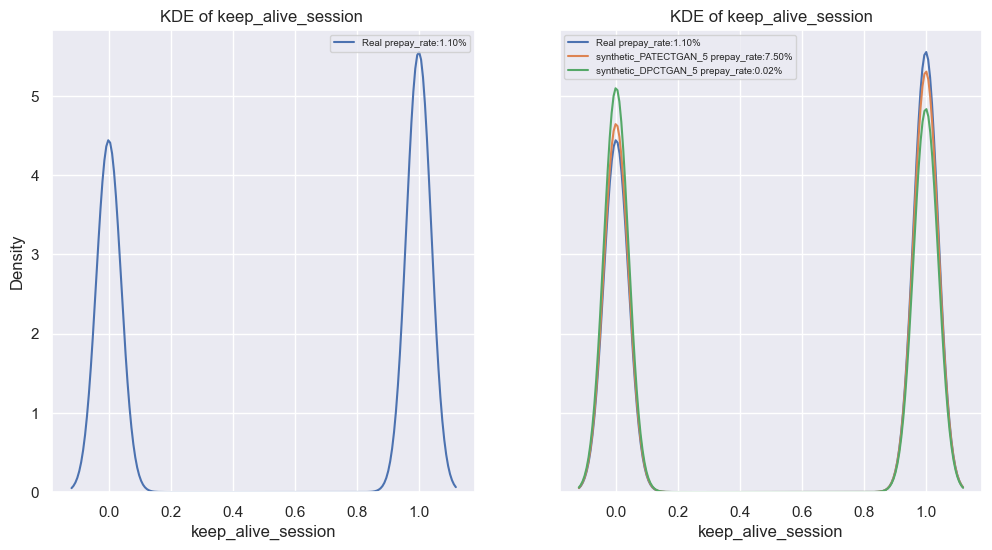

In [54]:
dp_kde_quick(df_real,synth_dict,feature_list)

In [ ]:
logDict = {""}